In [6]:
pip install opencv-python tensorflow scikit-learn matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# ==== 1. Imports ====
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# For nicer plots
plt.rcParams["figure.figsize"] = (6, 4)

# ==== 2. Load CIFAR-10 ====
# CIFAR-10: 50,000 train, 10,000 test, 32x32 RGB images, 10 classes
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()
y_train_full = y_train_full.ravel()
y_test = y_test.ravel()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("Train full:", X_train_full.shape, "Test:", X_test.shape)


Train full: (50000, 32, 32, 3) Test: (10000, 32, 32, 3)


In [8]:
# ==== 3. OpenCV preprocessing function ====
def preprocess_image_cv2(img, size=32):
    # img is RGB 32x32x3 (uint8)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Resize (you can use 32 or 64; 32 is faster)
    gray = cv2.resize(gray, (size, size))
    
    # Adjust brightness and contrast
    # alpha: contrast, beta: brightness
    enhanced = cv2.convertScaleAbs(gray, alpha=1.3, beta=30)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
    
    # Normalize to [0, 1]
    norm = blurred.astype("float32") / 255.0
    return norm

# ==== 4. Apply preprocessing to train/test + create train/val split ====
def preprocess_dataset(X):
    return np.array([preprocess_image_cv2(img, size=32) for img in X])

X_train_full_proc = preprocess_dataset(X_train_full)
X_test_proc = preprocess_dataset(X_test)

# Train/validation split from training set
X_train_proc, X_val_proc, y_train, y_val = train_test_split(
    X_train_full_proc, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print("Train processed:", X_train_proc.shape)
print("Val processed:", X_val_proc.shape)
print("Test processed:", X_test_proc.shape)


Train processed: (40000, 32, 32)
Val processed: (10000, 32, 32)
Test processed: (10000, 32, 32)


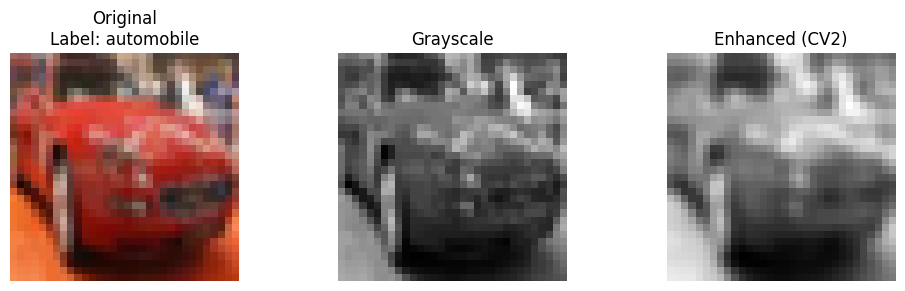

In [9]:
# ==== 5. Visualize original vs enhanced ====
def visualize_enhancement(idx=0):
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    
    # Original RGB
    axes[0].imshow(X_train_full[idx].astype("uint8"))
    axes[0].set_title(f"Original\nLabel: {class_names[y_train_full[idx]]}")
    axes[0].axis("off")
    
    # Grayscale original
    gray_orig = cv2.cvtColor(X_train_full[idx], cv2.COLOR_RGB2GRAY)
    axes[1].imshow(gray_orig, cmap="gray")
    axes[1].set_title("Grayscale")
    axes[1].axis("off")
    
    # Enhanced (after preprocess)
    axes[2].imshow(X_train_full_proc[idx], cmap="gray")
    axes[2].set_title("Enhanced (CV2)")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_enhancement(idx=5)


In [10]:
# ==== 6. Flatten images for classifier ====
n_train, h, w = X_train_proc.shape
n_val = X_val_proc.shape[0]
n_test = X_test_proc.shape[0]

X_train_flat = X_train_proc.reshape(n_train, -1)
X_val_flat   = X_val_proc.reshape(n_val, -1)
X_test_flat  = X_test_proc.reshape(n_test, -1)

print("Feature dimension:", X_train_flat.shape[1])

# ==== 7. Train linear SVM via SGDClassifier ====
sgd_svm = SGDClassifier(
    loss="hinge",       # linear SVM
    alpha=1e-4,
    max_iter=20,        # epochs over data; can increase to 50 if you want
    random_state=42,
    n_jobs=-1
)

sgd_svm.fit(X_train_flat, y_train)

# ==== 8. Evaluate ====
y_pred_train = sgd_svm.predict(X_train_flat)
y_pred_val   = sgd_svm.predict(X_val_flat)
y_pred_test  = sgd_svm.predict(X_test_flat)

print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Val accuracy:   {accuracy_score(y_val,   y_pred_val):.4f}")
print(f"Test accuracy:  {accuracy_score(y_test,  y_pred_test):.4f}")


Feature dimension: 1024
Train accuracy: 0.1292
Val accuracy:   0.1232
Test accuracy:  0.1229


/Users/snithshibu/Documents/Mulearn/#cl-ai-imageclassification/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/snithshibu/Documents/Mulearn/#cl-ai-imageclassification/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/snithshibu/Documents/Mulearn/#cl-ai-imageclassification/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/snithshibu/Documents/Mulearn/#cl-ai-imageclassification/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/snithshibu/Documents/Mulearn/#cl-ai-imageclassification/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: Runt

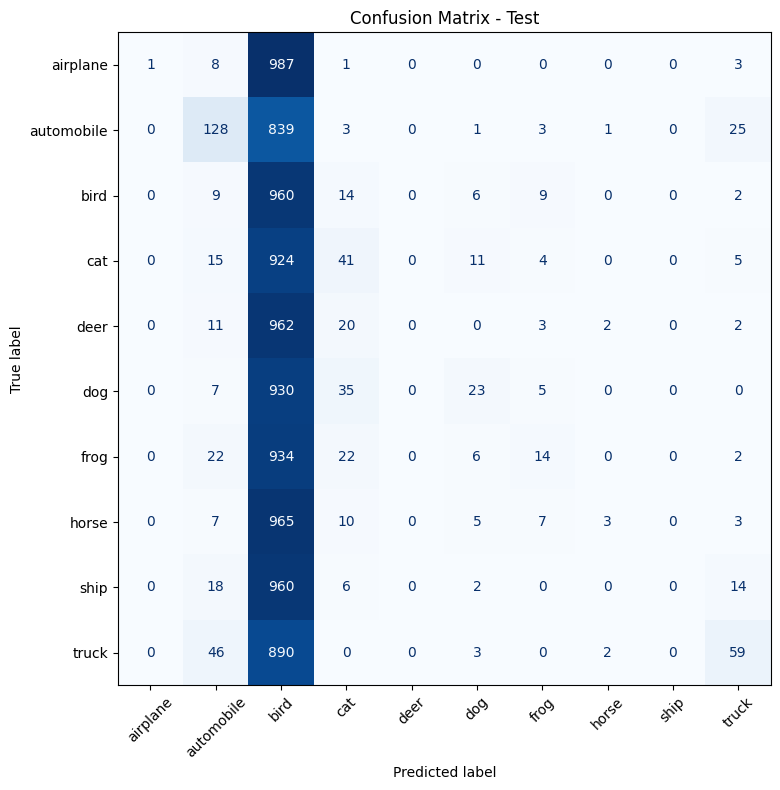

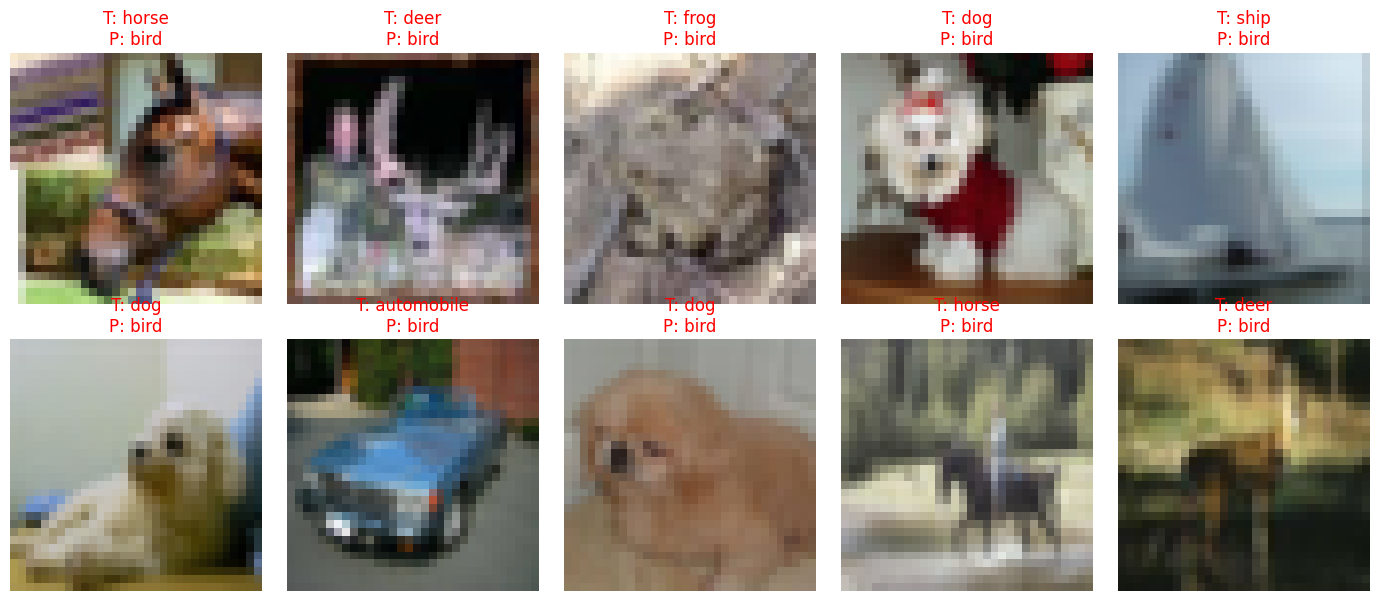

In [11]:
# ==== 9. Confusion matrix on test set ====
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix - Test")
plt.tight_layout()
plt.show()

# ==== 10. Show a few test images with predicted vs true labels ====
def show_test_predictions(num_samples=10):
    idxs = np.random.choice(len(X_test), size=num_samples, replace=False)
    rows = 2
    cols = num_samples // rows

    fig, axes = plt.subplots(rows, cols, figsize=(14, 6))
    axes = axes.ravel()

    for i, idx in enumerate(idxs):
        axes[i].imshow(X_test[idx].astype("uint8"))
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred_test[idx]]
        color = "green" if y_test[idx] == y_pred_test[idx] else "red"
        axes[i].set_title(f"T: {true_label}\nP: {pred_label}", color=color)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

show_test_predictions(num_samples=10)
